<a href="https://colab.research.google.com/github/ebudd45/Meteorologyclass/blob/main/stormofthecentury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Magic to make Cartopy work
!pip install cartopy
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -q -c conda-forge cartopy
import cartopy
cartopy.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!


'0.21.1'

In [3]:
#!mamba install -q -c conda-forge cartopy

In [4]:
#import cartopy
#cartopy.__version__

In [5]:
#Install needed modules
!pip install metpy
!pip install cartopy
!pip install siphon
!pip install netcdf4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.8/387.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.2/981.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.5/269.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 11.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 

In [32]:
#Import needed modules
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
from metpy.plots import StationPlot
from metpy.units import units
from netCDF4 import Dataset, num2date
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr

In [33]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 12

dt = datetime(year, month, day, hour)

In [43]:
# Read NARR Data from THREDDS server
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/'

# Programmatically generate the URL to the day of data we want
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')

# Have Siphon find the appropriate dataset
ds = cat.datasets.filter_time_nearest(dt)

# Interface with the data through the NetCDF Subset Service (NCSS)
ncss = ds.subset()

# Create an NCSS query with our desired specifications
query = ncss.query()
query.lonlat_box(north=60, south=18, east=300, west=225)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

# Use the query to obtain our NetCDF data
data = ncss.get_data(query)

In [35]:
# Back up in case of bad internet connection.
# Uncomment the following line to read local netCDF file of NARR data
# data = Dataset('../../../data/NARR_19930313_0000.nc','r')

In [41]:
data.dimensions
print(cat)

No name found


In [39]:
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: North American Regional Reanalysis Project
    GRIB_table_version: 0,131
    Generating_process_or_model: North American Regional Reanalysis (NARR)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = DatasetScan#narr-a_221_19930313_1200_000.grb; Translation Date = 2023-03-23T21:04:59.288Z
    geospatial_lat_min: 10.753308882144761
    geospatial_lat_max: 46.8308828962289
    geospatial_lon_min: -153.88242040519995
    geospatial_lon_max: -42.666108129242815
    dimensions(sizes): time1(1), isobaric1(29), y(119), x(268)
    variables(dimensions): float32 u-component_of_wind_isobaric(time1, i

In [12]:
# Extract data and assign units
tmpk = gaussian_filter(data.variables['Temperature_isobaric'][0],
                       sigma=1.0) * units.K
hght = gaussian_filter(data.variables['Geopotential_height_isobaric'][0],
                       sigma=1.0) * units.meter
uwnd = gaussian_filter(data.variables['u-component_of_wind_isobaric'][0], sigma=1.0) * units('m/s')
vwnd = gaussian_filter(data.variables['v-component_of_wind_isobaric'][0], sigma=1.0) * units('m/s')

# Extract coordinate data for plotting
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev = data.variables['isobaric1'][:]

In [13]:
#Extract time
time = data.variables['time1']
print(time.units)
vtime = num2date(time[0], units=time.units)
print(vtime)

Hour since 1993-03-13T12:00:00Z
1993-03-13 12:00:00


In [14]:
# Calcualte dx and dy for calculations
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

In [66]:
# Specify 850 hPa data
ilev850 = np.where(lev == 850)[0][0]
hght_850 = hght[ilev850]
tmpk_850 = tmpk[ilev850]
uwnd_850 = uwnd[ilev850]
vwnd_850 = vwnd[ilev850]

# Specify 500 hPa data
ilev500 = np.where(lev == 500)[0][0]
hght_500 = hght[ilev500]
uwnd_500 = uwnd[ilev500]
vwnd_500 = vwnd[ilev500]

# Specify 300 hPa data
ilev300 = np.where(lev == 300)[0][0]
hght_300 = hght[ilev300]
uwnd_300 = uwnd[ilev300]
vwnd_300 = vwnd[ilev300]

#specify surface data
ilevelsfc = np.where(lev == 1000)[0][0]
sfc_temp = tmpk[ilevelsfc]

In [16]:
# Temperature Advection
tmpc_adv_850 = mpcalc.advection(tmpk_850, uwnd_850, vwnd_850, dx=dx, dy=dy)

In [17]:
# Planetary Vorticity
f = mpcalc.coriolis_parameter(np.deg2rad(lat)).to('1/s')

# Relative Vorticity
vor_500 = mpcalc.vorticity(uwnd_500, vwnd_500, dx=dx, dy=dy)

# Abosolute Vorticity
avor_500 = vor_500 + f

In [18]:
# Vorticity Advection
f_adv = mpcalc.advection(f, uwnd_500, vwnd_500, dx=dx, dy=dy)

relvort_adv = mpcalc.advection(vor_500, uwnd_500, vwnd_500, dx=dx, dy=dy)

absvort_adv = mpcalc.advection(avor_500, uwnd_500, vwnd_500, dx=dx, dy=dy)

In [19]:
# Stretching Vorticity
div_500 = mpcalc.divergence(uwnd_500, vwnd_500, dx=dx, dy=dy)

stretch_vort = -1 * avor_500 * div_500

In [47]:
# Divergence 300 hPa, Ageostrophic Wind
wspd_300 = mpcalc.wind_speed(uwnd_300, vwnd_300).to('kts')

#div_300 = mpcalc.divergence(uwnd_300, vwnd_300, dx=dx, dy=dy)
#ugeo_300, vgeo_300 = mpcalc.geostrophic_wind(hght_300, f, dx=dx, dy=dy)

#uageo_300 = uwnd_300 - ugeo_300
#vageo_300 = vwnd_300 - vgeo_300

TypeError: ignored

In [21]:
# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100., central_latitude=40.,
                                 standard_parallels=[30, 60])

In [22]:
def create_map_background():
    fig=plt.figure(figsize=(14, 12))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-125, -73, 25, 50],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=0.75)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    return fig, ax

/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


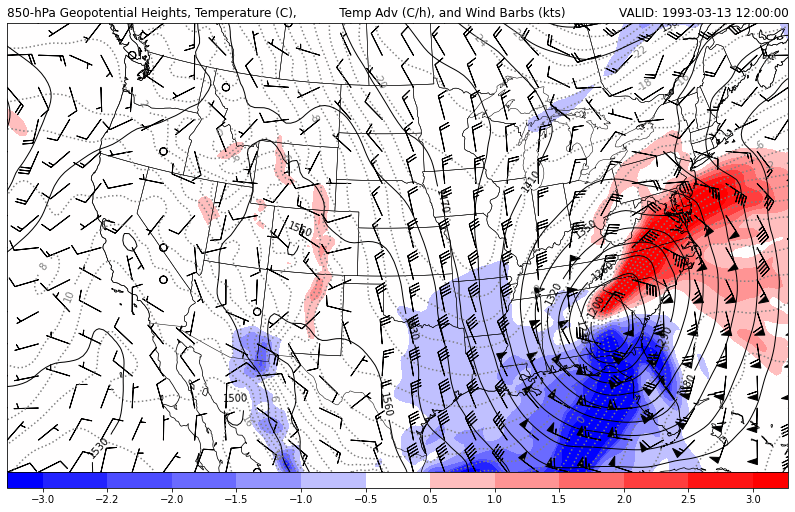

In [23]:
#Plot temperature advection
fig, ax = create_map_background()

# Contour 1 - Temperature, dotted
cs2 = ax.contour(lon, lat, tmpk_850.to('degC'), range(-50, 50, 2),
                 colors='grey', linestyles='dotted', transform=dataproj)

plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour 2
clev850 = np.arange(0, 4000, 30)
cs = ax.contour(lon, lat, hght_850, clev850, colors='k',
                linewidths=1.0, linestyles='solid', transform=dataproj)

plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Filled contours - Temperature advection
contours = [-3, -2.2, -2, -1.5, -1, -0.5, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
cf = ax.contourf(lon, lat, tmpc_adv_850*3600, contours,
                 cmap='bwr', extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50,
             extendrect=True, ticks=contours)

# Vector
ax.barbs(lon, lat, uwnd_850.to('kts').m, vwnd_850.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('850-hPa Geopotential Heights, Temperature (C), \
          Temp Adv (C/h), and Wind Barbs (kts)', loc='left')
plt.title(f'VALID: {vtime}', loc='right')

plt.show()

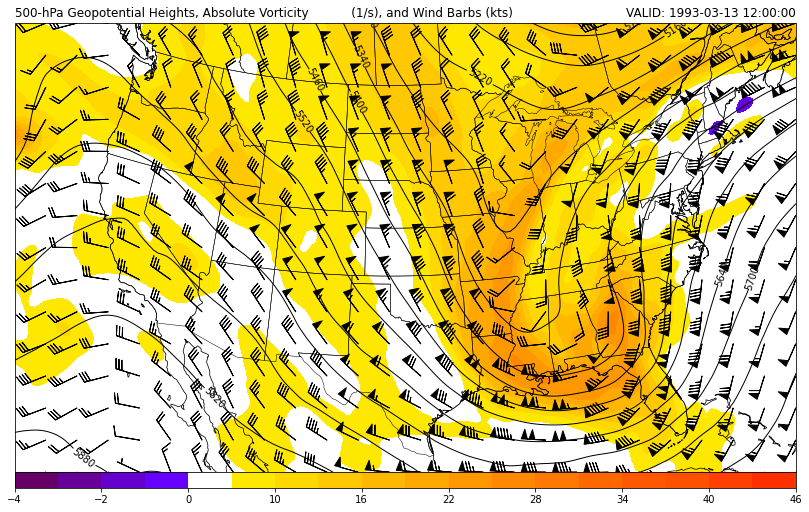

In [24]:
#Plot vorticity
fig, ax = create_map_background()

# Contour 1
clev500 = np.arange(0, 7000, 60)
cs = ax.contour(lon, lat, hght_500, clev500, colors='k',
                linewidths=1.0, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=4,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Filled contours
# Set contour intervals for Absolute Vorticity
clevavor500 = [-4, -3, -2, -1, 0, 7, 10, 13, 16, 19,
               22, 25, 28, 31, 34, 37, 40, 43, 46]

# Set colorfill colors for absolute vorticity
# purple negative
# yellow to orange positive
colorsavor500 = ('#660066', '#660099', '#6600CC', '#6600FF',
                 '#FFFFFF', '#ffE800', '#ffD800', '#ffC800',
                 '#ffB800', '#ffA800', '#ff9800', '#ff8800',
                 '#ff7800', '#ff6800', '#ff5800', '#ff5000',
                 '#ff4000', '#ff3000')

cf = ax.contourf(lon, lat, avor_500 * 10**5, clevavor500,
                 colors=colorsavor500, transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Vector
ax.barbs(lon, lat, uwnd_500.to('kts').m, vwnd_500.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('500-hPa Geopotential Heights, Absolute Vorticity \
          (1/s), and Wind Barbs (kts)', loc='left')
plt.title(f'VALID: {vtime}', loc='right')

plt.show()

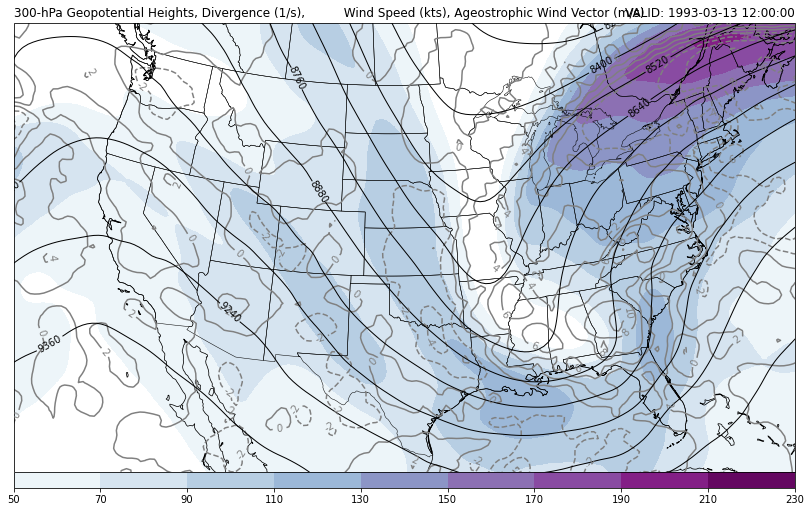

In [48]:
#Plot 300mb windspeeds and divergence
fig, ax = create_map_background()

# Contour 1
clev300 = np.arange(0, 11000, 120)
cs2 = ax.contour(lon, lat, div_300 * 10**5, range(-10, 11, 2),
                 colors='grey', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=4,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour 2
cs = ax.contour(lon, lat, hght_300, clev300, colors='k',
                linewidths=1.0, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=4,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Filled Contours
spd300 = np.arange(50, 250, 20)
cf = ax.contourf(lon, lat, wspd_300, spd300, cmap='BuPu',
                 transform=dataproj, zorder=0)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50)

# Vector of 300-hPa Ageostrophic Wind Vectors
#ax.quiver(lon, lat, uageo_300.m, vageo_300.m, regrid_shape=15,
#          pivot='mid', transform=dataproj, zorder=10)

# Titles
plt.title('300-hPa Geopotential Heights, Divergence (1/s),\
          Wind Speed (kts), Ageostrophic Wind Vector (m/s)',
          loc='left')
plt.title(f'VALID: {vtime}', loc='right')

plt.show()

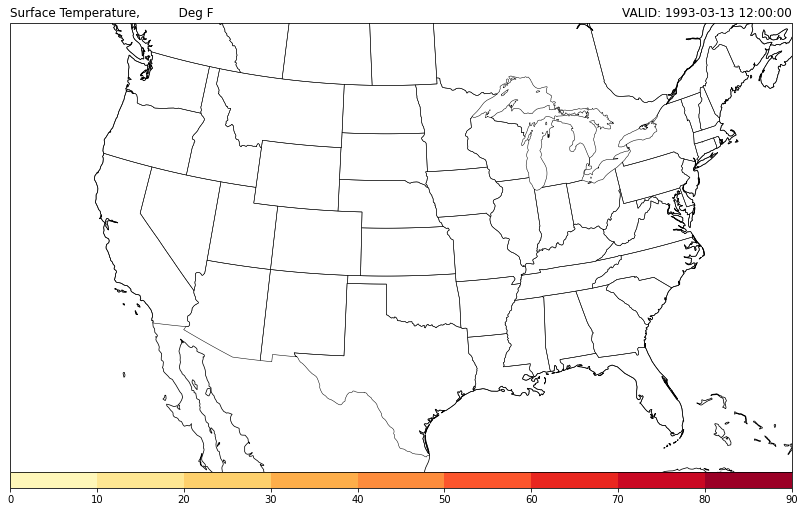

In [67]:
#Plot surface temperature- NEEDS WORK!
fig, ax = create_map_background()

#Filled contours
temp = np.arange(0, 100, 10)
cf = ax.contourf(lon, lat, sfc_temp, temp, cmap='YlOrRd',
                         transform=dataproj, zorder=0)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50)

# Titles
plt.title('Surface Temperature,\
          Deg F',
          loc='left')
plt.title(f'VALID: {vtime}', loc='right')

plt.show()